In [2]:
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,feature_selection
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [3]:
from sklearn import feature_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [47]:
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [4]:
review1=pd.read_csv(r'C:\Users\11638\Favorites\Code\Project\Review_project_sentiment_wUser.csv')

In [5]:
review1.head(2)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,language,text_clean,read_ease,polarity,subjectivity,Adj_ratio,review_count,NumElite,average_stars,NumofWords
0,1073206,JdReKgETiiJEDmshrO4TLw,pyarmAnR-i-qookQamqRTA,V2GOReqPvr8qpCC7sWfoTw,1.0,17,1,0,Just to let this car company that people DO re...,2014-03-06 12:38:52,...,en,let car company people read yelp check review ...,85.49,-0.500000,1.000000,0.120000,9,0,3.00,56
1,6229216,zL4se_Ixdcl8kvTOHCS3rg,s16-BUo-orUsELvMu5ocKg,VH0Ib9S3E-dxbQdQC4rffg,1.0,15,6,4,Mistral was the worst dining experience I have...,2010-07-22 18:08:01,...,en,mistral worst dining experience ever life bad ...,79.19,0.029864,0.502499,0.225888,1777,10,3.82,767


In [6]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=(1,1))

In [7]:
X=review1["text_clean"]

In [8]:
Y = np.array(review1["useful_level"].values)

In [9]:
## split dataset
X_train, X_test,y_train,y_test = model_selection.train_test_split(X,Y, test_size=0.1,stratify=Y)# 10% test size
## get target
#y_train = dtf_train["useful_level"].values
#y_test = np.array(dtf_test["useful_level"].values)

In [10]:
X_train1, X_valid,y_train1,y_valid = model_selection.train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)# 20% validation

In [11]:
corpus1 = X_train1
vectorizer.fit(corpus1)
X_train = vectorizer.transform(corpus1)
dic_vocabulary = vectorizer.vocabulary_

In [12]:
X_train.shape

(39734, 5000)

In [13]:
X_valid.shape

(9934,)

In [14]:
y_train1.shape

(39734,)

In [15]:
y_valid

array([2, 1, 1, ..., 0, 1, 0], dtype=int64)

In [16]:
y = y_train1
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [17]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 0:
  . selected features: 1624
  . top features: amazing,call,company,food,great,told,atmosphere,review,delicious,said
 
# 1:
  . selected features: 599
  . top features: great,car,apartment,food,office,call,told,said,dog,doctor
 
# 2:
  . selected features: 436
  . top features: tattoo,park,ride,food,great,mall,store,grandson,located,pavilion
 


In [18]:
# refit vecorizor
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus1)
X_train1 = vectorizer.transform(corpus1)
dic_vocabulary = vectorizer.vocabulary_

In [19]:
X_train1.shape

(39734, 1725)

In [31]:
# validation
#corpus2 = X_valid
#X_valid=vectorizer.transform(corpus2)
#corpus2 = dtf_test["text_clean"]
#X_test= vectorizer.transform(corpus2)

In [34]:
# X test
#corpus3 = X_test
#X_test = vectorizer.transform(corpus3)

# Def Funtion Evaluate Model

In [58]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import itertools

def model_evaluation(classifier):
    t0 = time()
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train1, y_train1.astype(int))
    
    ## validation
    predicted = model.predict(X_valid)
    predicted_prob = model.predict_proba(X_valid)
    print('Training Time:', time() - t0)
    print('')
    accuracy = metrics.accuracy_score(y_valid, predicted)
    auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                                multi_class="ovr")

    print('\033[1m' + 'Validation Set')
    print('\033[0m')
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print('Macros:')
    print("F1 Score:", f1_score(y_valid, predicted, average='macro'))
    print("Precision:", precision_score(y_valid, predicted, average='macro'))
    print("Recall:", recall_score(y_valid, predicted, average='macro'))
    print('Micros:')
    print("F1 Score:", f1_score(y_valid, predicted, average='micro'))
    print("Precision:", precision_score(y_valid, predicted, average='micro'))
    print("Recall:", recall_score(y_valid, predicted, average='micro'))
    print("Detail:")
    print(metrics.classification_report(y_valid, predicted))
    
    ## Test Set
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
    model["classifier"].fit(X_train1, y_train1.astype(int))
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print('\033[1m' + 'Test Set')
    print('\033[0m')
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print('Macros:')
    print("F1 Score:", f1_score(y_test, predicted, average='macro'))
    print("Precision:", precision_score(y_test, predicted, average='macro'))
    print("Recall:", recall_score(y_test, predicted, average='macro'))
    print('Micros:')
    print("F1 Score:", f1_score(y_test, predicted, average='micro'))
    print("Precision:", precision_score(y_test, predicted, average='micro'))
    print("Recall:", recall_score(y_test, predicted, average='micro'))

    print("Detail Report:")
    print(metrics.classification_report(y_test, predicted))
    
    ##ROC Plot
    y_test1 = label_binarize(y_test, classes=[0, 1, 2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test1[:, i], predicted_prob[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    colors = itertools.cycle(['blue', 'red', 'green'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=0.6,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=0.6)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

# Losgistic Regression

Training Time: 9.957059383392334

Validation Set

Accuracy: 0.62
Auc: 0.79
Macros:
F1 Score: 0.575629287120931
Precision: 0.584837590321065
Recall: 0.5756821517208782
Micros:
F1 Score: 0.6208979263136702
Precision: 0.6208979263136702
Recall: 0.6208979263136702
Detail:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      4361
           1       0.53      0.52      0.52      3124
           2       0.51      0.38      0.43      2449

    accuracy                           0.62      9934
   macro avg       0.58      0.58      0.58      9934
weighted avg       0.61      0.62      0.61      9934

Test Set

Accuracy: 0.62
Auc: 0.78
Macros:
F1 Score: 0.5706683974425063
Precision: 0.5801817205465388
Recall: 0.570651770287016
Micros:
F1 Score: 0.615328863924624
Precision: 0.615328863924624
Recall: 0.615328863924624
Detail Report:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2423
       

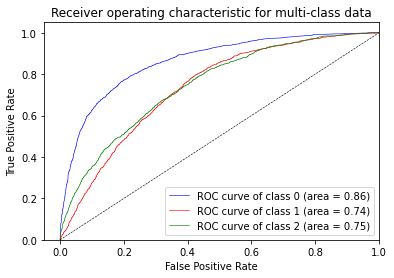

In [59]:
model_evaluation(classifier = LogisticRegression(max_iter = 1000))

# naive_bayes.MultinomialNB

Training Time: 1.7691187858581543

Validation Set

Accuracy: 0.56
Auc: 0.72
Macros:
F1 Score: 0.4884576165442025
Precision: 0.5432324519126608
Recall: 0.5026260225255963
Micros:
F1 Score: 0.5627139118179988
Precision: 0.5627139118179988
Recall: 0.5627139118179988
Detail:
              precision    recall  f1-score   support

           0       0.62      0.81      0.70      4361
           1       0.48      0.52      0.50      3124
           2       0.53      0.18      0.27      2449

    accuracy                           0.56      9934
   macro avg       0.54      0.50      0.49      9934
weighted avg       0.55      0.56      0.53      9934

Test Set

Accuracy: 0.56
Auc: 0.73
Macros:
F1 Score: 0.48844020984965436
Precision: 0.5443453339444074
Recall: 0.5041091496841305
Micros:
F1 Score: 0.564051458597572
Precision: 0.564051458597572
Recall: 0.564051458597572
Detail Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      2423
  

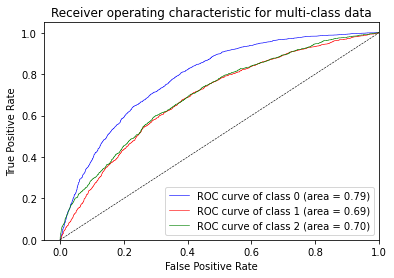

In [60]:
model_evaluation(classifier = naive_bayes.MultinomialNB())

# KNN

Training Time: 51.63541650772095

Validation Set

Accuracy: 0.48
Auc: 0.66
Macros:
F1 Score: 0.3331468591438343
Precision: 0.48833449652647837
Recall: 0.3904482209239824
Micros:
F1 Score: 0.47815582846788807
Precision: 0.47815582846788807
Recall: 0.47815582846788807
Detail:
              precision    recall  f1-score   support

           0       0.48      0.95      0.63      4361
           1       0.47      0.10      0.17      3124
           2       0.52      0.12      0.19      2449

    accuracy                           0.48      9934
   macro avg       0.49      0.39      0.33      9934
weighted avg       0.48      0.48      0.38      9934

Test Set

Accuracy: 0.47
Auc: 0.65
Macros:
F1 Score: 0.32846439006114014
Precision: 0.47948474807441926
Recall: 0.3866696940382
Micros:
F1 Score: 0.47490487407138976
Precision: 0.47490487407138976
Recall: 0.47490487407138976
Detail Report:
              precision    recall  f1-score   support

           0       0.47      0.94      0.63      

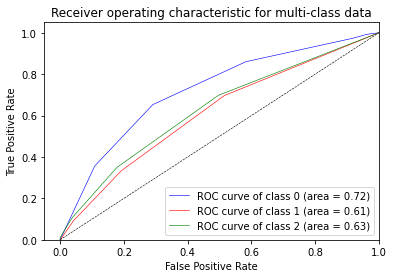

In [61]:
model_evaluation(classifier = KNeighborsClassifier())

# XGB

C:\Users\11638\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Time: 118.17320942878723

Validation Set

Accuracy: 0.61
Auc: 0.78
Macros:
F1 Score: 0.5596240185545185
Precision: 0.5809730655025646
Recall: 0.5611584694990669
Micros:
F1 Score: 0.6113348097443124
Precision: 0.6113348097443124
Recall: 0.6113348097443124
Detail:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      4361
           1       0.51      0.53      0.52      3124
           2       0.54      0.32      0.40      2449

    accuracy                           0.61      9934
   macro avg       0.58      0.56      0.56      9934
weighted avg       0.60      0.61      0.60      9934



C:\Users\11638\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set

Accuracy: 0.61
Auc: 0.78
Macros:
F1 Score: 0.5566579193391008
Precision: 0.5783071863727088
Recall: 0.5592408194622623
Micros:
F1 Score: 0.6091683275955789
Precision: 0.6091683275955789
Recall: 0.6091683275955789
Detail Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      2423
           1       0.51      0.55      0.53      1736
           2       0.53      0.30      0.39      1360

    accuracy                           0.61      5519
   macro avg       0.58      0.56      0.56      5519
weighted avg       0.60      0.61      0.59      5519



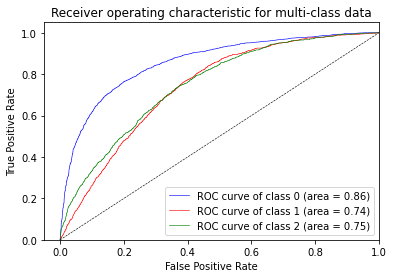

In [62]:
import xgboost as xgb
model_evaluation(classifier = xgb.XGBClassifier())

# Decision Tree

Training Time: 51.310356855392456

Validation Set

Accuracy: 0.5
Auc: 0.61
Macros:
F1 Score: 0.46947290709612394
Precision: 0.4694422210012141
Recall: 0.46961918913055817
Micros:
F1 Score: 0.500503321924703
Precision: 0.500503321924703
Recall: 0.500503321924703
Detail:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      4361
           1       0.42      0.41      0.41      3124
           2       0.36      0.35      0.35      2449

    accuracy                           0.50      9934
   macro avg       0.47      0.47      0.47      9934
weighted avg       0.50      0.50      0.50      9934

Test Set

Accuracy: 0.51
Auc: 0.61
Macros:
F1 Score: 0.474962858125538
Precision: 0.4755540296701057
Recall: 0.4748781173433521
Micros:
F1 Score: 0.5058887479615872
Precision: 0.5058887479615872
Recall: 0.5058887479615872
Detail Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      2423
   

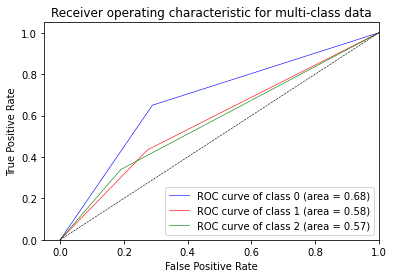

In [63]:
model_evaluation(classifier = tree.DecisionTreeClassifier())

# RandomForest

Training Time: 197.50030827522278

Validation Set

Accuracy: 0.6
Auc: 0.77
Macros:
F1 Score: 0.5104972452889965
Precision: 0.5839328136663403
Recall: 0.5317827097908535
Micros:
F1 Score: 0.5979464465472116
Precision: 0.5979464465472116
Recall: 0.5979464465472116
Detail:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      4361
           1       0.50      0.58      0.54      3124
           2       0.59      0.16      0.25      2449

    accuracy                           0.60      9934
   macro avg       0.58      0.53      0.51      9934
weighted avg       0.59      0.60      0.56      9934

Test Set

Accuracy: 0.59
Auc: 0.77
Macros:
F1 Score: 0.5043421042094299
Precision: 0.5796895162653192
Recall: 0.5277439913033363
Micros:
F1 Score: 0.5930422177930784
Precision: 0.5930422177930784
Recall: 0.5930422177930784
Detail Report:
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      2423
 

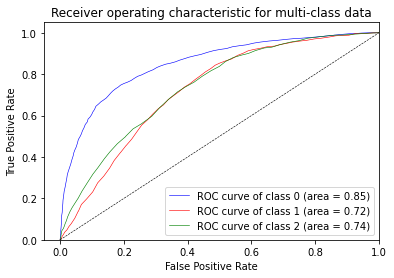

In [64]:
model_evaluation(classifier = RandomForestClassifier())

# MLP

Training Time: 313.4867527484894

Validation Set

Accuracy: 0.58
Auc: 0.74
Macros:
F1 Score: 0.546439016086731
Precision: 0.5472760936834123
Recall: 0.5461861884665087
Micros:
F1 Score: 0.5787195490235555
Precision: 0.5787195490235555
Recall: 0.5787195490235555
Detail:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      4361
           1       0.48      0.47      0.47      3124
           2       0.46      0.43      0.44      2449

    accuracy                           0.58      9934
   macro avg       0.55      0.55      0.55      9934
weighted avg       0.57      0.58      0.58      9934

Test Set

Accuracy: 0.58
Auc: 0.74
Macros:
F1 Score: 0.5497172079393332
Precision: 0.5501538486999785
Recall: 0.549507062953255
Micros:
F1 Score: 0.5801775684000725
Precision: 0.5801775684000725
Recall: 0.5801775684000725
Detail Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2423
   

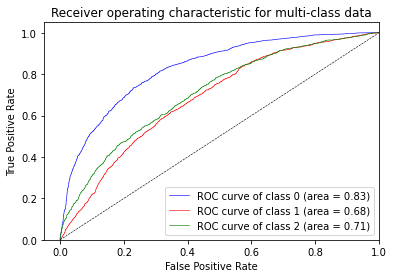

In [65]:
model_evaluation(classifier = MLPClassifier(random_state=1, max_iter=500))

# 剩下都是之前run的,别看

In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("F1 Score:", f1_score( y_valid, predicted, average='macro'))
print("Precision:", precision_score(y_valid, predicted, average='macro'))
print("Recall:", recall_score(y_valid, predicted, average='macro'))

print("Detail:")
print(metrics.classification_report(y_valid, predicted))

Accuracy: 0.48
Auc: 0.66
F1 Score: 0.3331468591438343
Precision: 0.48833449652647837
Recall: 0.3904482209239824
Detail:
              precision    recall  f1-score   support

           0       0.48      0.95      0.63      4361
           1       0.47      0.10      0.17      3124
           2       0.52      0.12      0.19      2449

    accuracy                           0.48      9934
   macro avg       0.49      0.39      0.33      9934
weighted avg       0.48      0.48      0.38      9934



In [35]:
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.47
Auc: 0.65
Detail:
              precision    recall  f1-score   support

           0       0.47      0.94      0.63      2423
           1       0.49      0.11      0.18      1736
           2       0.48      0.11      0.18      1360

    accuracy                           0.47      5519
   macro avg       0.48      0.39      0.33      5519
weighted avg       0.48      0.47      0.38      5519



# XGB

In [44]:
import xgboost as xgb
t0 = time()
classifier = xgb.XGBClassifier()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_valid)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_valid)
print('Training Time:', time() - t0)
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score( y_valid, predicted, average='macro' )
p = precision_score(y_valid, predicted, average='macro')
r = recall_score(y_valid, predicted, average='macro')
print(f1, p, r)

C:\Users\11638\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Time: 116.71235227584839
0.5596240185545185 0.5809730655025646 0.5611584694990669


In [45]:
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_valid, predicted))

Accuracy: 0.61
Auc: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      4361
           1       0.51      0.53      0.52      3124
           2       0.54      0.32      0.40      2449

    accuracy                           0.61      9934
   macro avg       0.58      0.56      0.56      9934
weighted avg       0.60      0.61      0.60      9934



In [46]:
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

C:\Users\11638\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.61
Auc: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      2423
           1       0.51      0.55      0.53      1736
           2       0.53      0.30      0.39      1360

    accuracy                           0.61      5519
   macro avg       0.58      0.56      0.56      5519
weighted avg       0.60      0.61      0.59      5519



# Decision Tree

In [48]:
t0 = time()
classifier = tree.DecisionTreeClassifier()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_valid)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_valid)
print('Training Time:', time() - t0)
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score( y_valid, predicted, average='macro' )
p = precision_score(y_valid, predicted, average='macro')
r = recall_score(y_valid, predicted, average='macro')
print(f1, p, r)

Training Time: 45.59788680076599
0.4651376759477237 0.4651554832892914 0.4652202140899586


In [49]:
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_valid, predicted))

Accuracy: 0.5
Auc: 0.6
Detail:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      4361
           1       0.41      0.41      0.41      3124
           2       0.35      0.34      0.34      2449

    accuracy                           0.50      9934
   macro avg       0.47      0.47      0.47      9934
weighted avg       0.49      0.50      0.50      9934



In [50]:
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.5
Auc: 0.61
Detail:
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      2423
           1       0.41      0.43      0.42      1736
           2       0.36      0.34      0.35      1360

    accuracy                           0.50      5519
   macro avg       0.47      0.47      0.47      5519
weighted avg       0.50      0.50      0.50      5519



# Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
classifier = RandomForestClassifier()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_valid)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_valid)
print('Training Time:', time() - t0)

#On Validation
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score( y_valid, predicted, average='macro' )
p = precision_score(y_valid, predicted, average='macro')
r = recall_score(y_valid, predicted, average='macro')
print(f1, p, r)
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_valid, predicted))

#On Test
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Training Time: 182.87185645103455
0.5084347985086829 0.5805793158118954 0.5299730788880169
Accuracy: 0.6
Auc: 0.77
Detail:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      4361
           1       0.50      0.58      0.54      3124
           2       0.58      0.15      0.24      2449

    accuracy                           0.60      9934
   macro avg       0.58      0.53      0.51      9934
weighted avg       0.59      0.60      0.56      9934

Accuracy: 0.6
Auc: 0.77
Detail:
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      2423
           1       0.50      0.61      0.55      1736
           2       0.60      0.15      0.24      1360

    accuracy                           0.60      5519
   macro avg       0.59      0.54      0.51      5519
weighted avg       0.60      0.60      0.56      5519



# Gradient Boosting Too Long

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
classifier = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=2)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_valid)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_valid)
print('Training Time:', time() - t0)

#On Validation
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score( y_valid, predicted, average='macro' )
p = precision_score(y_valid, predicted, average='macro')
r = recall_score(y_valid, predicted, average='macro')
print(f1, p, r)
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_valid, predicted))

#On Test
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Training Time: 1319.9150648117065
0.573564657688331 0.5970796610450392 0.5741304260581221
Accuracy: 0.62
Auc: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      4361
           1       0.53      0.54      0.53      3124
           2       0.56      0.34      0.42      2449

    accuracy                           0.62      9934
   macro avg       0.60      0.57      0.57      9934
weighted avg       0.61      0.62      0.61      9934



KeyboardInterrupt: 

# MLP

In [53]:
from sklearn.neural_network import MLPClassifier
t0 = time()
classifier = MLPClassifier(random_state=1, max_iter=500)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_valid)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_valid)
print('Training Time:', time() - t0)

#On Validation
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score( y_valid, predicted, average='macro' )
p = precision_score(y_valid, predicted, average='macro')
r = recall_score(y_valid, predicted, average='macro')
print(f1, p, r)
from sklearn.metrics import confusion_matrix
accuracy = metrics.accuracy_score(y_valid, predicted)
auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_valid, predicted))

#On Test
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train1, y_train1.astype(int))
## validation
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
#predicted = np.argmax(predicted,axis=1)
predicted_prob = model.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Training Time: 338.31313920021057
0.546439016086731 0.5472760936834123 0.5461861884665087
Accuracy: 0.58
Auc: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      4361
           1       0.48      0.47      0.47      3124
           2       0.46      0.43      0.44      2449

    accuracy                           0.58      9934
   macro avg       0.55      0.55      0.55      9934
weighted avg       0.57      0.58      0.58      9934

Accuracy: 0.58
Auc: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2423
           1       0.48      0.48      0.48      1736
           2       0.45      0.44      0.44      1360

    accuracy                           0.58      5519
   macro avg       0.55      0.55      0.55      5519
weighted avg       0.58      0.58      0.58      5519

